# Lab 4 - Visión Por Computadora

Autores:

- Nelson García
- Joaquín Puente
- Diego Linares

---

## Task 1: 

##### 1. Una homografía 𝐻 es una matriz de 3 × 3. 

##### 1.1 Explique matemáticamente por qué, aunque tiene 9 elementos, solo posee 8 grados de libertad (GDL). 

##### 1.2 Adicionalmente, respoda. Si tuviéramos una cámara que solo rota sobre su eje óptico (sin traslación ni cambio de perspectiva), ¿la matriz de transformación sigue teniendo 8 GDL o se reduce? Demuestre la estructura de dicha matriz simplificada.


##### 2. En el algoritmo DLT (Direct Linear Transform), convertimos el problema 𝑥' = 𝐻𝑥 en un sistema de la forma 𝐴ℎ = 0. Explique por qué buscamos el vector singular asociado al menor valor singular de 𝐴 en lugar de simplemente invertir la matriz. ¿Qué representa geométricamente ese "menor valor singular" cuando los datos tienen ruido?


##### 3. Si usted selecciona 4 puntos para calcular 𝐻, pero 3 de ellos son colineales (están en la misma línearecta), el algoritmo fallará. Explique algebraicamente qué le sucede a la matriz 𝐴 del sistema DLT en este caso y por qué no tiene solución única.


---

## Task 2:

El objetivo de esta parte es implementar el pipeline de alineación sin depender de cajas negras. Por ello
considere que no deben de usar cv2.findHonography o cv2.RANSAC. Además para este laboratorio
necesitara crear su propio dataset, por ello tome 3 fotografías propias de una escena planar (i.e. una
pancarta en una pared, un cuadro, o una fachada de edificio lejana) con ángulos y perspectivas
drásticamente diferentes. Con esto realice:

1. Detección y Macheo

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


def imread_color(path: str):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"No pude leer la imagen: {path}")
    return img

def to_gray(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

def create_feature(method: str):
    method = method.lower()
    if method == "sift":
        if not hasattr(cv2, "SIFT_create"):
            raise RuntimeError("Instala opencv-contrib-python para SIFT.")
        return cv2.SIFT_create()
    elif method == "orb":
        return cv2.ORB_create(nfeatures=4000)
    else:
        raise ValueError("method debe ser 'sift' o 'orb'")

def create_bf(method: str):
    method = method.lower()
    norm = cv2.NORM_L2 if method == "sift" else cv2.NORM_HAMMING
    return cv2.BFMatcher(normType=norm, crossCheck=False)

def draw_and_save_matches(img1_bgr, kp1, img2_bgr, kp2, matches, out_path, max_draw=600):
    matches_to_draw = matches[:max_draw] if len(matches) > max_draw else matches
    vis = cv2.drawMatches(img1_bgr, kp1, img2_bgr, kp2, matches_to_draw, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imwrite(out_path, vis)
    return vis

def show_bgr(img_bgr, title=""):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 7))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()




Normalizacion de puntos para mejorar la estabilidad numérica en RANSAC


In [ ]:
def normalizar_puntos(pts):
    """
    Recibe pts de forma (N, 2).
    Devuelve (pts_norm, T) donde T es la matriz 3×3 de normalización
    tal que pts_norm = (T @ pts_hom.T).T  (en coordenadas homogéneas).
    """
    mu = pts.mean(axis=0)           # centroide
    std = pts.std()                 # desviación estándar global
    std = max(std, 1e-8)            # evitar división por cero
    escala = np.sqrt(2) / std       # escala para que distancia media al origen ≈ √2

    T = np.array([
        [escala,  0,     -escala * mu[0]],
        [0,       escala,-escala * mu[1]],
        [0,       0,      1            ]
    ])

    # Convertir a homogéneos, aplicar T
    pts_h = np.column_stack([pts, np.ones(len(pts))])   # (N, 3)
    pts_n = (T @ pts_h.T).T                             # (N, 3)
    pts_norm = pts_n[:, :2]                             # (N, 2)
    return pts_norm, T


    Calcula la homografía H (3×3) que mapea puntos_src → puntos_dst.

    Parámetros
    ----------
    puntos_src : array-like (4, 2)  — puntos en imagen fuente
    puntos_dst : array-like (4, 2)  — puntos correspondientes en imagen destino

    Retorna
    -------
    H : ndarray (3, 3)  — matriz de homografía normalizada y escalada (H[2,2]=1)


Estima la homografía robusta usando RANSAC manual (sin cv2.findHomography/RANSAC).

Parámetros

    ----------

matches     : lista de cv2.DMatch ya filtrados (ratio test recomendado)

kp1, kp2    : keypoints de imagen 1 e imagen 2

umbral      : distancia máxima (px) para considerar un inlier

prob_exito  : probabilidad deseada de encontrar al menos una muestra libre de outliers

Retorna

    -------

H_best   : ndarray (3,3)  — mejor homografía encontrada

inliers  : lista de DMatch que son inliers

In [ ]:


def calcular_homografia_dlt(puntos_src, puntos_dst):

    pts_src = np.asarray(puntos_src, dtype=np.float64)
    pts_dst = np.asarray(puntos_dst, dtype=np.float64)

    assert pts_src.shape == (4, 2) and pts_dst.shape == (4, 2), \
        "Se requieren exactamente 4 pares de puntos."

    # --- Normalización ---
    src_n, T_src = normalizar_puntos(pts_src)
    dst_n, T_dst = normalizar_puntos(pts_dst)

    # --- Construir matriz A (8×9) ---
    A = np.zeros((8, 9))
    for i in range(4):
        x, y   = src_n[i]
        xp, yp = dst_n[i]
        A[2*i]   = [-x, -y, -1,  0,  0,  0,  xp*x,  xp*y,  xp]
        A[2*i+1] = [ 0,  0,  0, -x, -y, -1,  yp*x,  yp*y,  yp]

    # --- Resolver con SVD ---
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1]                      # último vector singular → solución
    H_n = h.reshape(3, 3)

    # --- Des-normalizar: H = T_dst^{-1} · H_n · T_src ---
    H = np.linalg.inv(T_dst) @ H_n @ T_src

    # Escalar para que H[2,2] = 1
    if abs(H[2, 2]) > 1e-10:
        H /= H[2, 2]

    return H

def ransac_homografia(matches, kp1, kp2, umbral=4.0, prob_exito=0.99):
    """

    """
    if len(matches) < 4:
        raise ValueError("Se necesitan al menos 4 matches para RANSAC.")

    # Extraer coordenadas
    pts1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float64)
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float64)

    n = len(matches)
    best_inlier_mask = np.zeros(n, dtype=bool)
    best_count = 0

    # Número de iteraciones N calculado dinámicamente
    # N = log(1 - p) / log(1 - w^4)  donde w = tasa inliers estimada
    # Iniciamos con w = 0.5 y actualizamos en cada iteración
    w_est = 0.5
    N = int(np.ceil(np.log(1 - prob_exito) / np.log(1 - w_est**4 + 1e-10)))
    N = max(N, 200)   # mínimo razonable
    N = min(N, 5000)  # techo para no colgar

    rng = np.random.default_rng(42)
    iteracion = 0

    while iteracion < N:
        # i) Seleccionar 4 matches aleatorios
        idx = rng.choice(n, size=4, replace=False)
        src4 = pts1[idx]
        dst4 = pts2[idx]

        # ii) Calcular homografía con DLT
        try:
            H_test = calcular_homografia_dlt(src4, dst4)
        except Exception:
            iteracion += 1
            continue

        # iii) Proyectar TODOS los puntos fuente con H_test
        pts1_h = np.column_stack([pts1, np.ones(n)])   # (N,3)
        proj   = (H_test @ pts1_h.T).T                  # (N,3)
        # Dividir por w (coordenada homogénea)
        denom  = proj[:, 2:3]
        denom  = np.where(np.abs(denom) < 1e-10, 1e-10, denom)
        proj_2d = proj[:, :2] / denom                   # (N,2)

        # iv) Error Euclidiano y contar inliers
        errores = np.linalg.norm(proj_2d - pts2, axis=1)
        mask    = errores < umbral
        count   = mask.sum()

        if count > best_count:
            best_count = count
            best_inlier_mask = mask.copy()
            # Actualizar N con nueva estimación de w
            w_est = count / n
            if w_est > 0 and w_est < 1:
                denom_log = np.log(max(1 - w_est**4, 1e-10))
                N_new = int(np.ceil(np.log(1 - prob_exito) / denom_log))
                N = min(max(N_new, iteracion + 1), 5000)

        iteracion += 1

    if best_count < 4:
        raise RuntimeError("RANSAC no encontró suficientes inliers.")

    # Refinamiento: recalcular H usando TODOS los inliers (SVD sobre sistema sobredeterminado)
    inlier_idx = np.where(best_inlier_mask)[0]
    src_in = pts1[inlier_idx]
    dst_in = pts2[inlier_idx]
    H_best = calcular_homografia_dlt_overdetermined(src_in, dst_in)

    inliers = [matches[i] for i in inlier_idx]
    print(f"  RANSAC: {iteracion} iters | inliers: {best_count}/{n}")
    return H_best, inliers


def calcular_homografia_dlt_overdetermined(pts_src, pts_dst):
    """
    Versión sobredeterminada de DLT para N ≥ 4 puntos.
    Construye A de tamaño (2N × 9) y resuelve con SVD.
    Incluye normalización/des-normalización igual que la versión exacta.
    """
    pts_src = np.asarray(pts_src, dtype=np.float64)
    pts_dst = np.asarray(pts_dst, dtype=np.float64)

    src_n, T_src = normalizar_puntos(pts_src)
    dst_n, T_dst = normalizar_puntos(pts_dst)

    N = len(pts_src)
    A = np.zeros((2 * N, 9))
    for i in range(N):
        x, y   = src_n[i]
        xp, yp = dst_n[i]
        A[2*i]   = [-x, -y, -1,  0,  0,  0,  xp*x,  xp*y,  xp]
        A[2*i+1] = [ 0,  0,  0, -x, -y, -1,  yp*x,  yp*y,  yp]

    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1]
    H_n = h.reshape(3, 3)

    H = np.linalg.inv(T_dst) @ H_n @ T_src
    if abs(H[2, 2]) > 1e-10:
        H /= H[2, 2]
    return H

In [5]:
def match_pair(img1_path, img2_path, method="sift", out_dir="out",
               unfiltered_draw=800, filtered_draw=300, ratio=0.75):
    os.makedirs(out_dir, exist_ok=True)

    img1 = imread_color(img1_path)
    img2 = imread_color(img2_path)
    gray1 = to_gray(img1)
    gray2 = to_gray(img2)

    feat = create_feature(method)
    bf   = create_bf(method)

    kp1, des1 = feat.detectAndCompute(gray1, None)
    kp2, des2 = feat.detectAndCompute(gray2, None)

    if des1 is None or des2 is None or len(kp1) < 10 or len(kp2) < 10:
        raise RuntimeError("Muy pocos keypoints. Intenta ORB o mejor iluminación/escena.")

    # (c) Matches SIN filtrar — con ruido visible
    raw_matches = bf.match(des1, des2)
    raw_matches = sorted(raw_matches, key=lambda m: m.distance)

    out_unf = os.path.join(out_dir, f"unfiltered_{method}_{os.path.basename(img1_path)}__{os.path.basename(img2_path)}.png")
    vis_unf = draw_and_save_matches(img1, kp1, img2, kp2, raw_matches, out_unf, max_draw=unfiltered_draw)

    # Ratio test (Lowe)
    knn  = bf.knnMatch(des1, des2, k=2)
    good = [m for m, n in knn if m.distance < ratio * n.distance]
    good = sorted(good, key=lambda m: m.distance)

    out_f = os.path.join(out_dir, f"filtered_ratio_{method}_{os.path.basename(img1_path)}__{os.path.basename(img2_path)}.png")
    vis_f = draw_and_save_matches(img1, kp1, img2, kp2, good, out_f, max_draw=filtered_draw)

    print("====================================")
    print(f"Par: {img1_path}  <->  {img2_path}")
    print(f"Método: {method}")
    print(f"Keypoints: img1={len(kp1)} img2={len(kp2)}")
    print(f"Matches (sin filtrar): {len(raw_matches)}")
    print(f"Matches (ratio test):  {len(good)}")
    print(f"Guardado sin filtrar:  {out_unf}")
    print(f"Guardado filtrado:     {out_f}")

    # RANSAC manual
    H, inliers = ransac_homografia(good, kp1, kp2, umbral=4.0, prob_exito=0.99)
    print(f"Inliers RANSAC: {len(inliers)}/{len(good)}")
    print("====================================")

    # Visualizar inliers
    out_ransac = os.path.join(out_dir, f"ransac_{method}_{os.path.basename(img1_path)}__{os.path.basename(img2_path)}.png")
    vis_ransac = draw_and_save_matches(img1, kp1, img2, kp2, inliers, out_ransac, max_draw=filtered_draw)

    show_bgr(vis_unf,    title=f"UNFILTERED matches ({method})")
    show_bgr(vis_f,      title=f"FILTERED ratio test ({method})")
    show_bgr(vis_ransac, title=f"INLIERS RANSAC ({method})")

    return H, kp1, kp2, inliers

### STITCHING (panorama de dos imágenes)

H mapea puntos de img2 → img1

Necesitamos detectar/emparejar en el orden correcto:

si queremos warpear img2 al plano de img1 necesitamos H: img2 → img1

matches: queryIdx en img1, trainIdx en img2

RANSAC recibe (kp1, kp2) y estima H tal que kp2 → kp1

Para warpear img2 usamos H directamente.

In [ ]:
def stitch_pair(img1_path, img2_path, method="sift", out_dir="out", ratio=0.75):
    """
    Genera un panorama alineando img2 sobre img1 usando la homografía calculada.
    img1 se toma como referencia (plano destino).
    """
    os.makedirs(out_dir, exist_ok=True)

    img1 = imread_color(img1_path)
    img2 = imread_color(img2_path)

    gray1 = to_gray(img1)
    gray2 = to_gray(img2)

    feat = create_feature(method)
    bf   = create_bf(method)

    kp1, des1 = feat.detectAndCompute(gray1, None)
    kp2, des2 = feat.detectAndCompute(gray2, None)

    knn  = bf.knnMatch(des1, des2, k=2)
    good = [m for m, n in knn if m.distance < ratio * n.distance]


    H, inliers = ransac_homografia(good, kp1, kp2, umbral=4.0, prob_exito=0.99)

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Calcular canvas que contenga ambas imágenes
    corners_img2 = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]], dtype=np.float64)
    corners_h    = np.column_stack([corners_img2, np.ones(4)])
    proj         = (H @ corners_h.T).T
    proj_2d      = proj[:, :2] / proj[:, 2:3]

    all_corners = np.vstack([
        [[0, 0], [w1, 0], [w1, h1], [0, h1]],
        proj_2d
    ])

    x_min, y_min = all_corners.min(axis=0).astype(int)
    x_max, y_max = all_corners.max(axis=0).astype(int)

    offset = np.array([-x_min, -y_min], dtype=np.float64)
    T_offset = np.array([
        [1, 0, offset[0]],
        [0, 1, offset[1]],
        [0, 0, 1        ]
    ])

    canvas_w = x_max - x_min
    canvas_h = y_max - y_min

    # Warpear img2 al canvas
    H_adjusted = T_offset @ H
    warped2 = cv2.warpPerspective(img2, H_adjusted, (canvas_w, canvas_h))

    # Colocar img1 en canvas
    panorama = warped2.copy()
    x0, y0   = int(offset[0]), int(offset[1])
    panorama[y0:y0+h1, x0:x0+w1] = img1

    out_path = os.path.join(out_dir, f"panorama_{os.path.basename(img1_path)}__{os.path.basename(img2_path)}.png")
    cv2.imwrite(out_path, panorama)
    print(f"Panorama guardado: {out_path}")

    show_bgr(panorama, title="Panorama (stitched)")
    return panorama, H


Par: img1.jpeg  <->  img2.jpeg
Método: sift
Keypoints: img1=1401 img2=1247
Matches (sin filtrar): 1401
Matches (ratio test):  119
Guardado sin filtrar:  out\unfiltered_sift_img1.jpeg__img2.jpeg.png
Guardado filtrado:     out\filtered_ratio_sift_img1.jpeg__img2.jpeg.png
  RANSAC: 34 iters | inliers: 71/119
Inliers RANSAC: 71/119


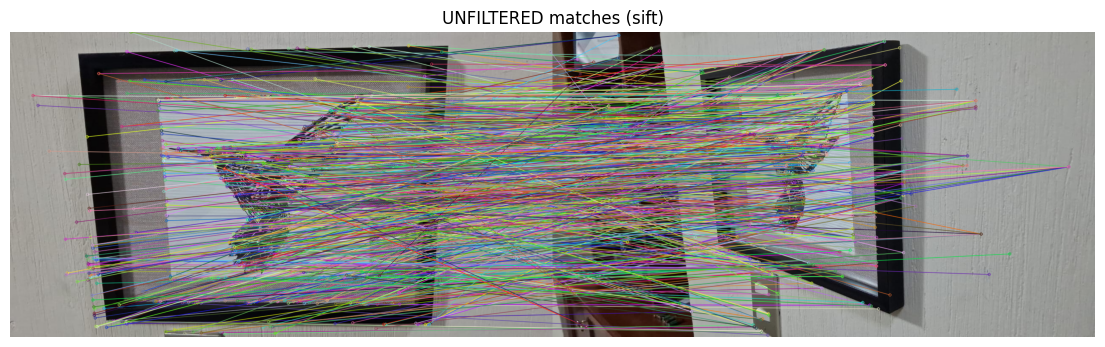

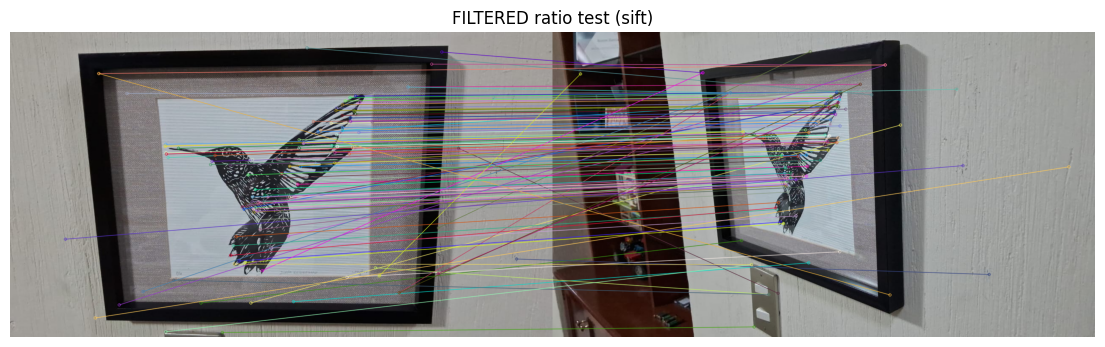

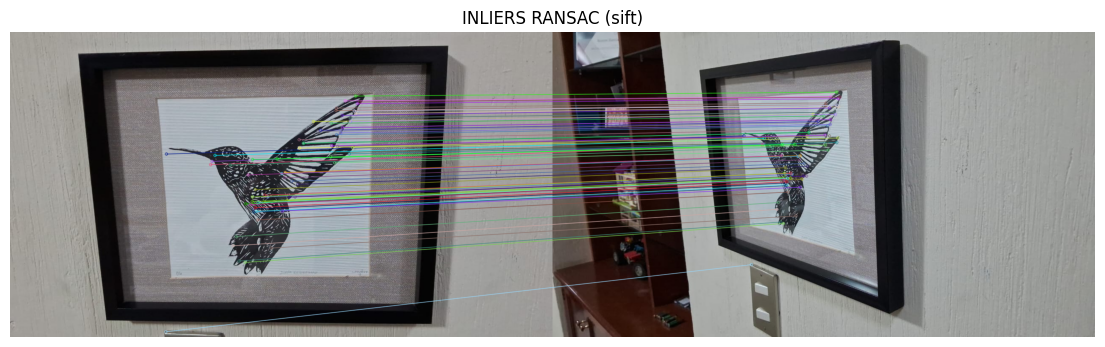

Par: img2.jpeg  <->  img3.jpeg
Método: sift
Keypoints: img1=1247 img2=1059
Matches (sin filtrar): 1247
Matches (ratio test):  64
Guardado sin filtrar:  out\unfiltered_sift_img2.jpeg__img3.jpeg.png
Guardado filtrado:     out\filtered_ratio_sift_img2.jpeg__img3.jpeg.png
  RANSAC: 585 iters | inliers: 20/64
Inliers RANSAC: 20/64


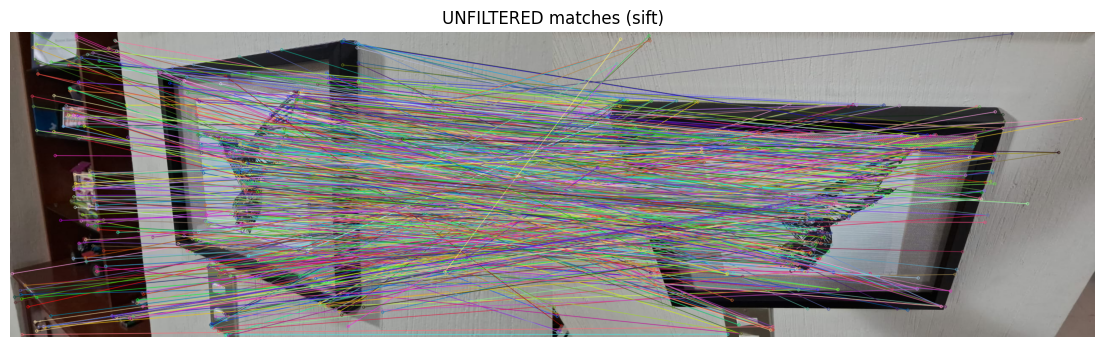

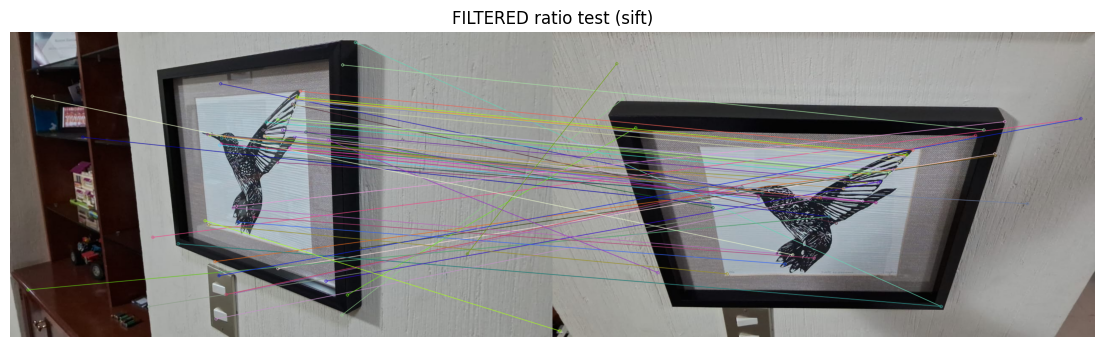

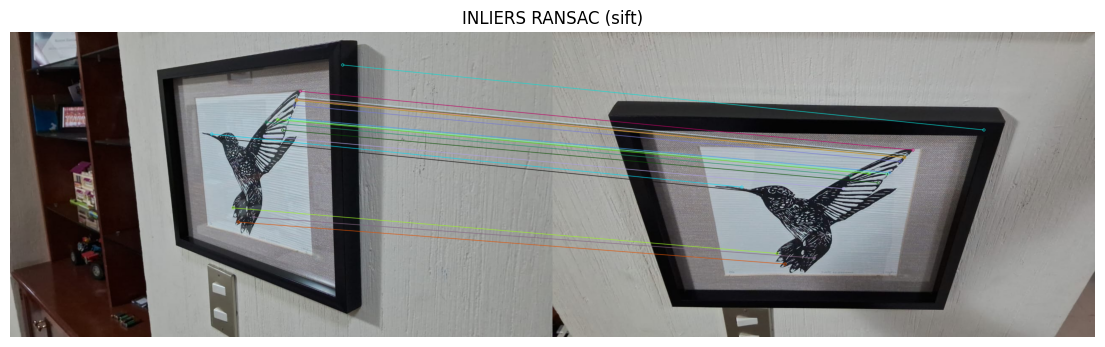

Par: img1.jpeg  <->  img3.jpeg
Método: sift
Keypoints: img1=1401 img2=1059
Matches (sin filtrar): 1401
Matches (ratio test):  301
Guardado sin filtrar:  out\unfiltered_sift_img1.jpeg__img3.jpeg.png
Guardado filtrado:     out\filtered_ratio_sift_img1.jpeg__img3.jpeg.png
  RANSAC: 9 iters | inliers: 241/301
Inliers RANSAC: 241/301


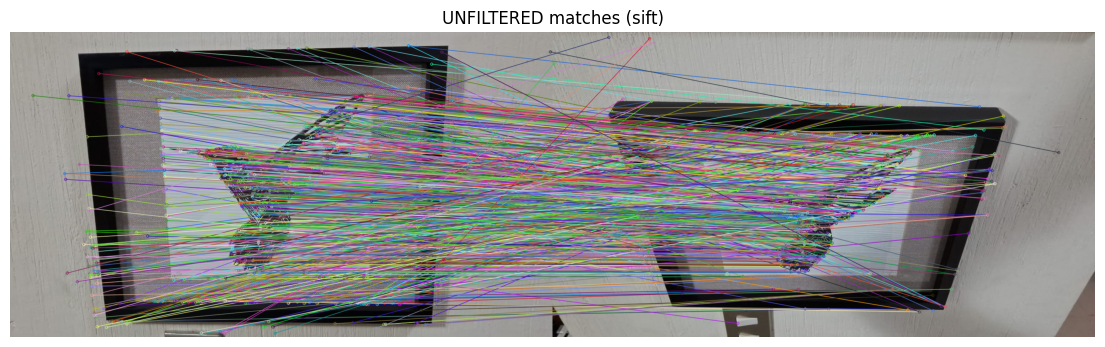

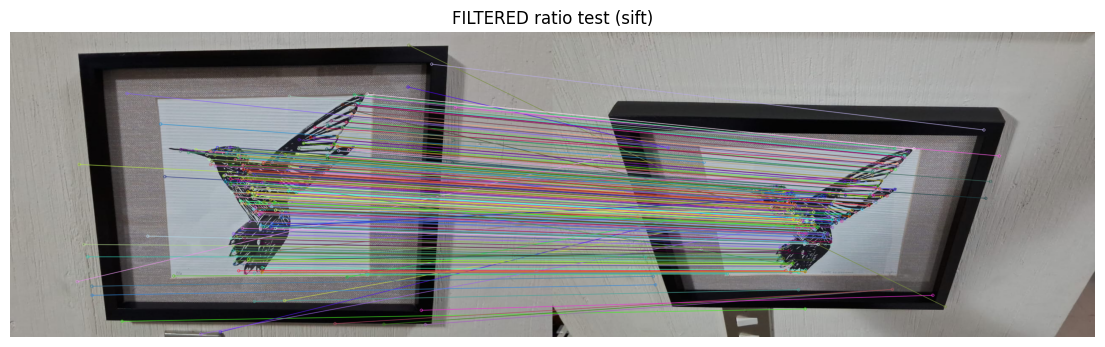

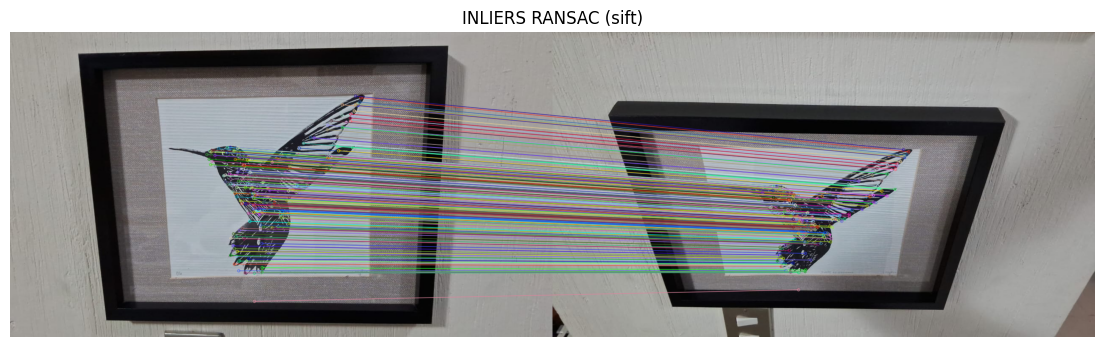

  RANSAC: 33 iters | inliers: 72/119
Panorama guardado: out\panorama_img1.jpeg__img2.jpeg.png


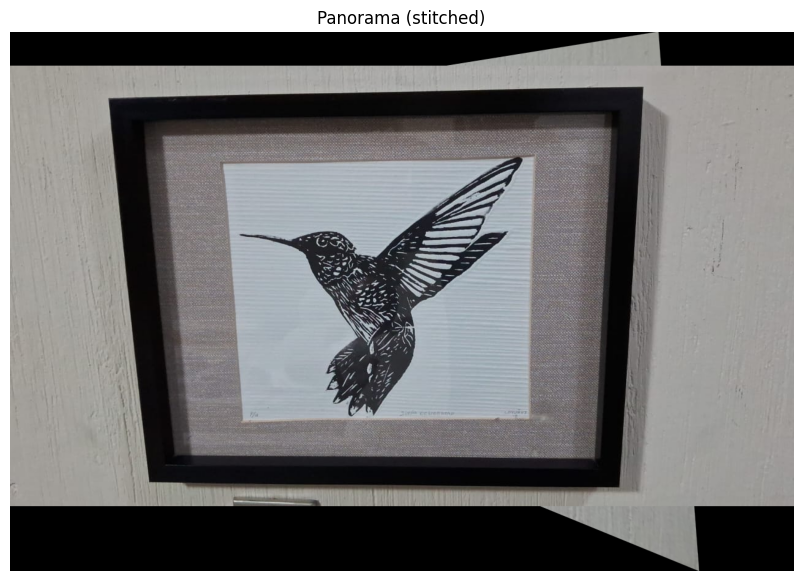

  RANSAC: 395 iters | inliers: 21/64
Panorama guardado: out\panorama_img2.jpeg__img3.jpeg.png


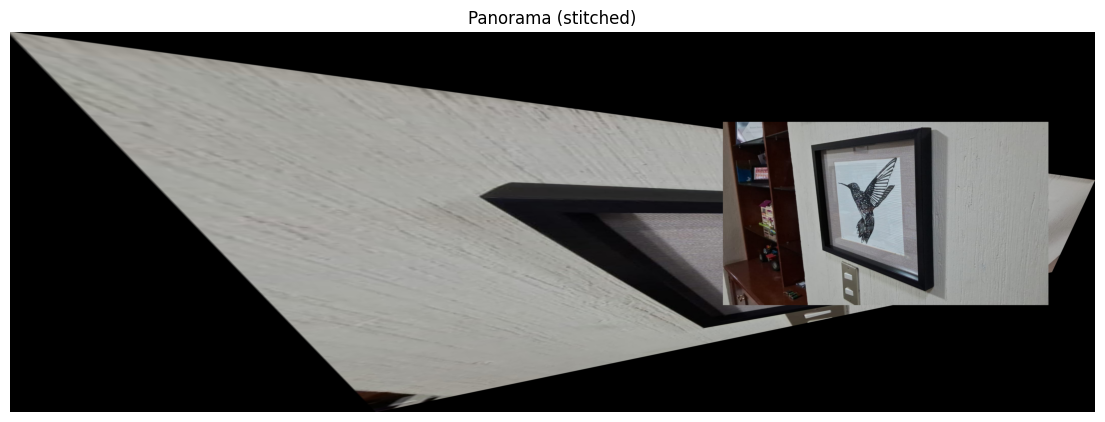

In [7]:
if __name__ == "__main__":
    imgA = "img1.jpeg"
    imgB = "img2.jpeg"
    imgC = "img3.jpeg"
    method = "sift"   # cambia a "orb" si no tienes opencv-contrib

    # --- Detección, matching y visualización (con y sin filtro, con RANSAC) ---
    match_pair(imgA, imgB, method=method, out_dir="out")
    match_pair(imgB, imgC, method=method, out_dir="out")
    match_pair(imgA, imgC, method=method, out_dir="out")

    # --- Stitching (panoramas) ---
    stitch_pair(imgA, imgB, method=method, out_dir="out")
    stitch_pair(imgB, imgC, method=method, out_dir="out")


Conclusion para sin filtro


Bueno una conclusion general de esto para las unfilterd las sin filtrar que pedia mucho ruido pues Las líneas van en direcciones caóticas, cruzándose sin patrón claro. Esto demuestra que el BFMatcher sin restricciones empareja prácticamente cualquier descriptor con cualquier otro, generando cientos de correspondencias falsas

Conclusion para Ratio test 

las líneas ya son mayoritariamente paralelas y horizontales, señal de que hay overlap real. El par img2↔img3 (imagen 2) también luce ordenado aunque hay algo de dispersión porque la perspectiva cambia mucho. El par img1↔img3 (imagen 3) es el más limpio de los tres.

Conclusion para Ransac

quedaron solo las correspondencias horizontales y consistentes. RANSAC eliminó los pocos outliers restantes y densísimo pero paralelo, lo que indica muchos inliers genuinos.

## Task 3